In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics.pairwise import euclidean_distances

# Exercise 12

In this exercise, we consider a small last-mile delivery system with one production location located outside the city and five delivery locations. The system and the corresponding coordinates are displayed in Figure 1. 

The goal of the exercise is to compare the performance of a crowd-shipping system to a traditional delivery system. 

Traditional delivery costs \\$4 per unit of distance traveled and \$1 per stop made. 

For crowd-shipper delivery, depot maintenance costs \\$5 per day, and every crowd-shipper is compensated \\$1 per delivery. 

Every failed delivery in a crowd-shipping system is outsourced to a third party which is penalized by \\$3 per parcel. 

The number of potential crowd-shippers that can make a delivery between every pair of nodes is indicated in matrix A.


For convenience, the coordinates of the production facility and the customer destinations can all be found in the “lecture12-data.mat” which can be found on Moodle. 

Coding for this exercise is generic and can be done in any programming language of your preference.

### Data Loading

In [2]:
data = scipy.io.loadmat("lecture12-data.mat")

A = data["A"]
customer_coordinates = data["customer_coordinates"]
demand = data["demand"]
depot_coordinates = data["depot_coordinates"]

### Question a)

Given the coordinates of the production facility and the delivery locations, we first evaluate the total costs of traditional delivery. Use a nearest-neighbor heuristic to solve a Travelling Salesman Problem (TSP) that starts and ends at the production facility. Report the total distance traveled, and the cost involved. Also, plot the coordinate system and the shortest tour.

Nearest neighbor heuristic:
1. Select the start location.
2. Find the nearest unvisited location and go there.
3. Are there any unvisited locations left? If yes, go to step 2. 4. Return to the start location.

In [3]:
start_location = depot_coordinates.reshape(-1)
unvisited_locations = list(range(5))

current_customer = -1
current_location = start_location
path = [current_location]
total_dist = 0

while(len(unvisited_locations) > 0):
    # calculates the distance between the current location and every unvisited locations
    dist_ls = [euclidean_distances(current_location.reshape(1, -1), customer_coordinates[_].reshape(1, -1))[0][0] for _ in unvisited_locations]
    
    # Go to the nearest unvisited location
    current_customer = unvisited_locations[np.argmin(dist_ls)]
    unvisited_locations.remove(current_customer) # Remove the visited node from the unvisited node
    current_location = customer_coordinates[current_customer]
    path.append(current_location)
    total_dist += np.min(dist_ls)

# From last customer to the depot
path.append(start_location) # Add this last path
total_dist += euclidean_distances(current_location.reshape(1, -1), start_location.reshape(1, -1))[0][0] # Add its distance

path = np.stack(path)

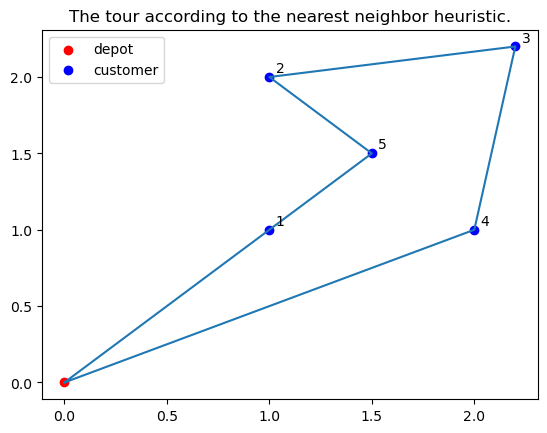

In [4]:
# Plot the shortest tour
plt.plot(path[:, 0], path[:, 1])

# Plot the locations of the depot and customers
plt.scatter(depot_coordinates[:, 0], depot_coordinates[:, 1], c="red", label="depot")
plt.scatter(customer_coordinates[:, 0], customer_coordinates[:, 1], c="blue", label="customer")
# Labeling of the customer nodes (1, ..., 5)
for i, txt in enumerate(range(5)):
    plt.annotate(txt+1, (customer_coordinates[:, 0][i] + 0.03, customer_coordinates[:, 1][i] + 0.03))
    
plt.title("The tour according to the nearest neighbor heuristic.")
plt.legend()
plt.show()

In [5]:
# "Traditional delivery costs $4 per unit of distance traveled and $1 per stop made."
cost_traditional_delivery = 4
cost_traditional_stop = 1

cost_traditional = total_dist * cost_traditional_delivery + cost_traditional_stop * 5

In [6]:
print(f"The corresponding length of the tour {total_dist:.2f}, leading to a cost of {cost_traditional:.2f}")

The corresponding length of the tour 7.50, leading to a cost of 34.99


### Question b)

Given the coordinates of the production delivery locations, determine the geographically central location for a depot. Limit the options to one of the coordinates. That is, out of the five nodes, select the one that minimizes the total distance to the other four nodes.

**Answer**

The central node out of the five customer nodes is number 5. 

This can already be explored visually from the plot, but is obtained formally by summing the distances to all other nodes.

In [7]:
print("The summed distance to all other nodes:\n")
print(euclidean_distances(customer_coordinates).sum(axis=0))

print(f"\nIn terms of distance, the best depot location is node 5 with the total distance to all other nodes of {euclidean_distances(customer_coordinates).sum(axis=0).min():.2f}.")

The summed distance to all other nodes:

[4.40416306 4.33787285 5.12011078 4.33787285 3.11126984]

In terms of distance, the best depot location is node 5 with the total distance to all other nodes of 3.11.


### Question c)

Evaluate the potential of every node to construct a depot. Evaluate whether from that node, the other delivery locations can be served, the costs of the truck to get from the production facility to the depot and the penalty for undelivered parcels.


**Answer**

The best node in terms of cost is node number 1. To find this, we took every node as a candidate and evaluated the served and unserved parcels for every node. This allowed us to calculate the cost.

In [8]:
cost_depot_maintenance = 5
cost_crowdshipper_compensation = 1
cost_outsourced = 3

costs_crowdshipping = []

for depot_node in range(5):
    # cost = production_to_depot ($4 * linehaul) + depot maintenance ($5) + crowd_shipper compensations ($1 * crowdshipping_delivery) + ($3 * outsourced demand) + ($1 for the stop at the depot)
    depot_coordinates_crowdshipping = customer_coordinates[depot_node].reshape(1, -1)
    # distance from the production facility to the depot (line_haul)
    line_haul = euclidean_distances(depot_coordinates, depot_coordinates_crowdshipping)[0][0]
    
    supply = A[depot_node]
    
    crowdshipping_parcels_nb = 0
    outsourced_parcels_nb = 0
    
    for d, s in zip(demand.reshape(-1), supply):
        # 1 crowdshipping delivery covering all the demanded parcels
        if d <= s :
            crowdshipping_parcels_nb += d
        # crowdshipping delivery cannot cover all the demanded parcels, outsourcing required
        else:
            # If crowd-shipper partially covers the delivery
            if s > 0:
                crowdshipping_parcels_nb += s
            
            outsourced_parcels_nb += d-s # Nb of outsourced parcels
    
    cost = cost_traditional_delivery * line_haul + cost_depot_maintenance + cost_crowdshipper_compensation * crowdshipping_parcels_nb + cost_outsourced * outsourced_parcels_nb + 1
    print(f"Depot Node {depot_node+1} : Cost of ${cost:.2f}")
    costs_crowdshipping.append(cost)
    

Depot Node 1 : Cost of $32.66
Depot Node 2 : Cost of $45.94
Depot Node 3 : Cost of $49.45
Depot Node 4 : Cost of $39.94
Depot Node 5 : Cost of $57.49


In [9]:
print(f"The best node is Node {np.argmin(costs_crowdshipping)+1} with cost of ${np.min(costs_crowdshipping):.2f}")

The best node is Node 1 with cost of $32.66


### Question d)

Evaluate the difference in cost between the best option according to Question c) and the geographically central option derived in Question b).


**Answer**

The best node performs 43% better. The reason for this is that the number of crowd-shippers leaving node 5 is very low. Potentially, the location of node 5 is not well accessible by bikers due to water or elevation. Thereby, the cost for line-haul is lower between the depot and node 1.

In [10]:
print(f"Compared to the geographically central option (Node 5), Node 1 performs {100 - np.min(costs_crowdshipping) / costs_crowdshipping[-1] * 100:.2f} % better.")

Compared to the geographically central option (Node 5), Node 1 performs 43.19 % better.


### Question e)

Compare the results of the crowd-shipping system in Question c) to the traditional delivery evaluated in Question a). How would the results change if the cost per unit of distance traveled for traditional delivery are only \\$2?


**Answer**
For a cost of 4: crowd-shipping performs better
For a cost of 2: traditional delivery performs better
The difference can be explained by the relatively low service level. In the best node, 20% of the parcels need to be outsourced for a cost that is significantly higher than that of traditional delivery.

In [11]:
print("For a cost of 4 per unit of distance traveled for traditional delivery:")
print(f"The traidional delivery cost : ${cost_traditional:.2f} vs The crowdshipping cost : ${np.min(costs_crowdshipping):.2f}")
print(f"Crowd-shipping performs better")

For a cost of 4 per unit of distance traveled for traditional delivery:
The traidional delivery cost : $34.99 vs The crowdshipping cost : $32.66
Crowd-shipping performs better


In [12]:
# "Traditional delivery costs $2 per unit of distance traveled and $1 per stop made."
cost_traditional_delivery = 2

cost_traditional = total_dist * cost_traditional_delivery + cost_traditional_stop * 5

# Crowd-shipping delivery costs change as well as the traditional delivery cost changes.

In [13]:
print("For a cost of 2 per unit of distance traveled for traditional delivery:")
print(f"The traidional delivery cost : ${cost_traditional:.2f} vs The crowdshipping cost : ${29.83}")
print(f"Traditional delivery performs better")

For a cost of 2 per unit of distance traveled for traditional delivery:
The traidional delivery cost : $20.00 vs The crowdshipping cost : $29.83
Traditional delivery performs better
